In [1]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import os


In [2]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]


In [3]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)


# RQ2
# VULNERABILITIES

In [4]:
# Vulnerabilities
docker_vulnerabilities=pd.read_csv('../../docker/csv/used/docker_vulnerabilities.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
docker_vulnerabilities['urgency']=docker_vulnerabilities['urgency'].apply(lambda x: 'not assigned' if 'not' in x
                                                                        else x)
docker_vulnerabilities['urgency']=docker_vulnerabilities['urgency'].apply(lambda x: x.split('*')[0])
docker_vulnerabilities.drop_duplicates(inplace=True)
len(docker_vulnerabilities)

25686

Text(0.18, 1.15, 'Status:')

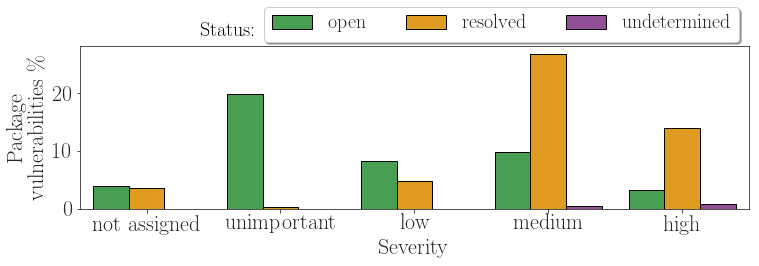

In [5]:

vuls=docker_vulnerabilities.groupby(['urgency','status']).count().reset_index()
vuls['source']=vuls['source']*100/len(docker_vulnerabilities)
vuls=vuls.sort_values('urgency', ascending=False)
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]

ax = sns.barplot(x="urgency", 
                 y="source", 
                 hue="status", 
                 order=['not assigned','unimportant', 'low', 'medium', 'high'],
                 data=vuls, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Package \n vulnerabilities \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')


In [6]:
vuls=docker_vulnerabilities.groupby(['status']).count().reset_index()
vuls['source']=(vuls['source']*100/len(docker_vulnerabilities)).apply(lambda x: "%.1f" % x)
vuls

,status,source,source_version,urgency,fixed_version,debianbug,release,cve
0,open,48.6,12479,12479,12479,12479,12479,12479
1,resolved,49.9,12806,12806,12806,12806,12806,12806
2,undetermined,1.6,401,401,401,401,401,401


In [7]:
###### Vulnerabilities with packages
lag_vul_all=pd.read_csv('../../docker/csv/used/lag_vul_all_correct.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
lag_vul_all['urgency']=lag_vul_all['urgency'].apply(lambda x: x.split('*')[0])
lag_vul_all['urgency']=lag_vul_all['urgency'].apply(lambda x: 'not assigned' if 'not' in x
                                                                        else x)
len(lag_vul_all)

9879982

In [8]:
print(lag_vul_all.query('status=="resolved"').groupby(['name']).count()[['cve']].cve.mean(),
      lag_vul_all.query('status=="resolved"').groupby(['name']).count()[['cve']].cve.median())

347.02878494326046 102.0


In [9]:
vuls=lag_vul_all[['name','urgency']].drop_duplicates().groupby(['urgency']).count().reset_index()
vuls['name']=vuls['name']*100/7380
vuls

,urgency,name
0,end-of-life,0.135501
1,high,100.000000
2,low,100.000000
3,medium,100.000000
4,not assigned,97.845528
5,unimportant,100.000000


In [10]:
# In case we want only unique cves per container
if False:
    lag_vul_all=lag_vul_all.loc[:,['name','source','source_version','created','cve','debian','date','isOudate',
                  'urgency','type','status','release_snapshot']]
    lag_vul_all=lag_vul_all.drop_duplicates()
    len(lag_vul_all)

(0, 6000)

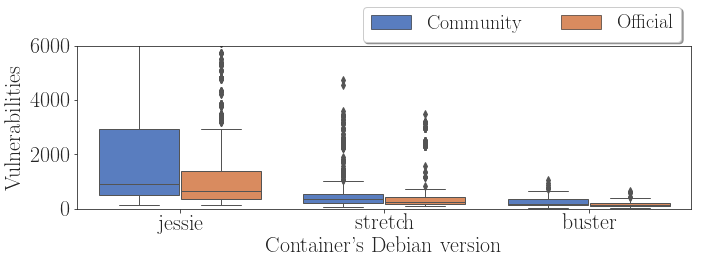

In [11]:
######### concatinating both dataframes : offical and community
if True:
    df_tmp=(lag_vul_all.
            groupby(['name','debian','type']).
            count().
            sort_values('source', ascending=False).
            reset_index()
           )

order=['jessie','stretch','buster']

ax = sns.boxplot(x="debian", y="source", data=df_tmp, hue="type", palette="muted", order=order, linewidth=1)
ax.figure.set_size_inches(11,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Vulnerabilities')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(0,6000)


In [12]:
for x in ['jessie','stretch','buster']:
    print(x)
    print(df_tmp.query('type=="Official"').query('debian=="'+x+'"').cve.min(),
          df_tmp.query('type=="Official"').query('debian=="'+x+'"').cve.median(),
          df_tmp.query('type=="Official"').query('debian=="'+x+'"').cve.max(),
      df_tmp.query('type=="Community"').query('debian=="'+x+'"').cve.min(),
         df_tmp.query('type=="Community"').query('debian=="'+x+'"').cve.median(),
         df_tmp.query('type=="Community"').query('debian=="'+x+'"').cve.max())


jessie
155 660.0 7106 155 916.0 7338
stretch
85 249.0 3498 75 342.5 4729
buster
34 136.5 659 41 192.0 1049


In [13]:
for x in ['jessie','stretch','buster']:
    print(x)
    cliffsDelta(df_tmp.query('type=="Community"').query('debian=="'+x+'"').cve, 
            df_tmp.query('type=="Official"').query('debian=="'+x+'"').cve)

jessie
d=0.16742100529202902
stretch
d=0.11575682382133995
buster
d=0.29643410852713176


In [14]:
for x in ['jessie','stretch','buster']:
    print(x,scipy.stats.mannwhitneyu(df_tmp.query('type=="Community"').query('debian=="'+x+'"').cve, 
            df_tmp.query('type=="Official"').query('debian=="'+x+'"').cve))

jessie MannwhitneyuResult(statistic=2517310.5, pvalue=4.7825331760449745e-23)
stretch MannwhitneyuResult(statistic=342096.0, pvalue=2.2523664529189984e-05)
buster MannwhitneyuResult(statistic=4538.0, pvalue=7.604045477807294e-05)


In [15]:
print('how many vulnerables sources:',len(lag_vul_all['source'].drop_duplicates()))


how many vulnerables sources: 489


In [16]:
if True:
    df_tmp=(lag_vul_all.
            groupby(['name','debian','type']).
            count().
            loc[:,['package']].
            reset_index()
           )
    df_tmp2=(lag_vul_all.query('isOutdate=="Out-of-date"').
             groupby(['name','debian','type','package','version']).
             count().
             loc[:,[]].
             reset_index().
             groupby(['name','debian','type']).
             count().
             reset_index().
             loc[:,['version','name']]
            )
    
    df_tmp3=(df_tmp2.merge(
        df_tmp,
        left_on='name',
        right_on='name',
        how='left')
            )
df_tmp3['version']=df_tmp3['version'].apply(int)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


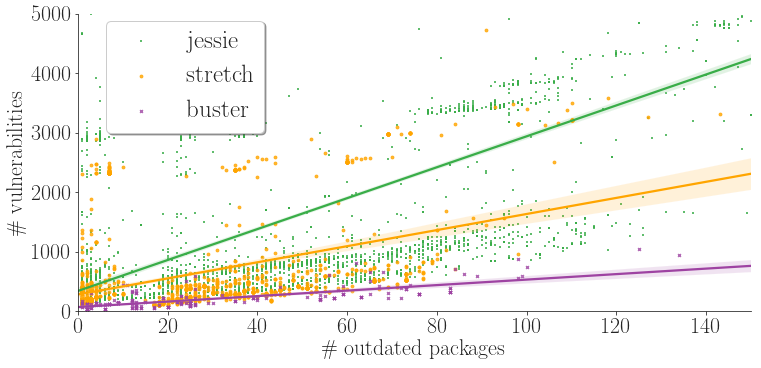

In [63]:
order=['jessie','stretch','buster']
ax = sns.lmplot(x="version", y="package", markers=["+", 'o','x'],
                hue="debian", palette=flatui, data=df_tmp3, scatter_kws={"s": 8},
                size=8, legend='', hue_order=order)
ax.fig.set_size_inches(12,5)
ax.set_ylabels('\# vulnerabilities')
ax.set_xlabels('\# outdated packages')
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.32, 1), fontsize=25, fancybox=True, shadow=True)# ,ncol=3)
ax.set(ylim=(0,5000), xlim=(0,150))
ax.fig.savefig('/home/neglectos/Desktop/thesis/Figs/docker/vuls_outdate.pdf', bbox_inches='tight', facecolor='white')

In [39]:
order=['jessie']
ax = sns.lmplot(x="version", y="package", markers=["+"], 
                color=flatui[0], data=df_tmp3.query('debian=="jessie"'), 
                size=8, legend='')
ax.fig.set_size_inches(12,3.5)
ax.set_ylabels('\# vulnerabilities')
ax.set_xlabels('\# outdated packages')
ax.set(ylim=(0,6100), xlim=(0,150))


TypeError: lmplot() got an unexpected keyword argument 'color'

In [44]:
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test.version,
                                                                         test.package)
    print("r-squared:", r_value**2)
    print('slope:',slope)

r-squared: 0.770658589113
slope: 17.9235873255
r-squared: 0.744130609955
slope: 6.15549668527
r-squared: 0.771535631896
slope: 5.50553823363


In [45]:
print('Up to date and only Resolved')
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    print(x,scipy.stats.pearsonr(test.package, test.version),'\n')
    
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    print(x,scipy.stats.spearmanr(test.package, test.version),'\n')
    
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    print(x,scipy.stats.kendalltau(test.package, test.version),'\n')

Up to date and only Resolved
jessie (0.87787162450637557, 0.0) 

stretch (0.86263005393674863, 0.0) 

buster (0.87837101039130661, 5.2896802022006786e-67) 

jessie SpearmanrResult(correlation=0.97890495483780871, pvalue=0.0) 

stretch SpearmanrResult(correlation=0.97767635261143704, pvalue=0.0) 

buster SpearmanrResult(correlation=0.95673386516847458, pvalue=8.4367697088744152e-111) 

jessie KendalltauResult(correlation=0.89104553424150101, pvalue=0.0) 

stretch KendalltauResult(correlation=0.8978358855396168, pvalue=0.0) 

buster KendalltauResult(correlation=0.85616115342471377, pvalue=2.5628317579296804e-69) 

